1. Import & Load Data

Class
0    284315
1       492
Name: count, dtype: int64


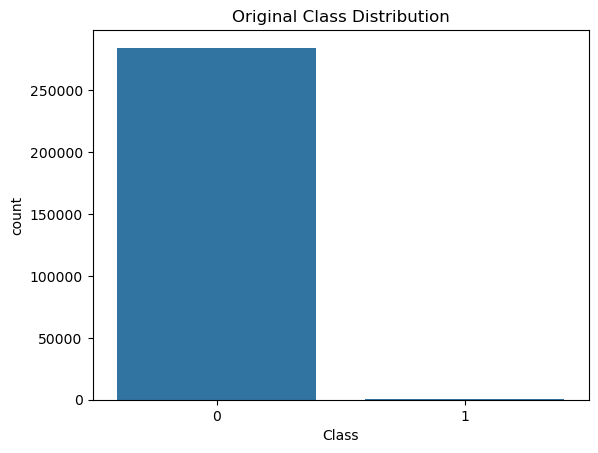

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('creditcard.csv')
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Original Class Distribution")
plt.savefig('ccf_class_dist.png')
plt.show()

2. Preprocessing

In [2]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df.drop(columns=['Time'], inplace=True)  # optional cleanup

X = df.drop('Class', axis=1)
y = df['Class']

3. Train/ Test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

4. Handle Imbalance with SMOTE

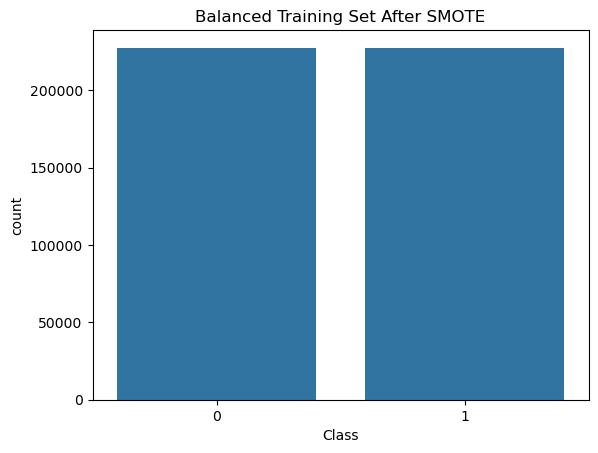

In [4]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

sns.countplot(x=y_train_res)
plt.title("Balanced Training Set After SMOTE")
plt.savefig('ccf_smote_dist.png')
plt.show()

5. Model Training

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(scale_pos_weight=1, eval_metric='logloss', use_label_encoder=False, random_state=42)

for model in [logreg, rf, xgb]:
    model.fit(X_train_res, y_train_res)

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
print("Models trained successfully:")
print(logreg)
print(rf)
print(xgb)

Models trained successfully:
LogisticRegression(class_weight='balanced', max_iter=1000)
RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


6. Evaluation

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} metrics:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name.lower()}_cm.png")
    plt.show()

    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"{name} ROC Curve")
    plt.savefig(f"{name.lower()}_roc.png")
    plt.show()

# for name, model in [("LogisticReg", logreg), ("RandomForest", rf), ("XGBoost", xgb)]:
#     evaluate(model, X_test, y_test, name)


LogisticReg metrics:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962



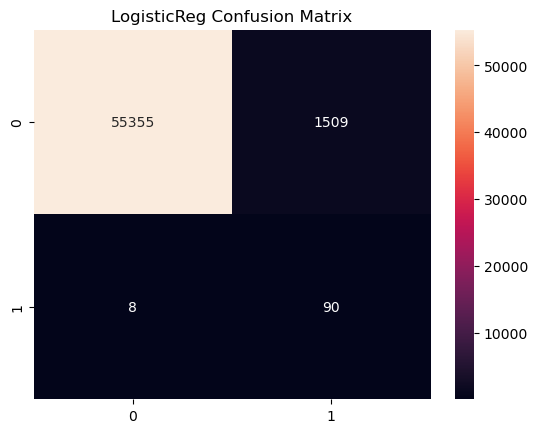

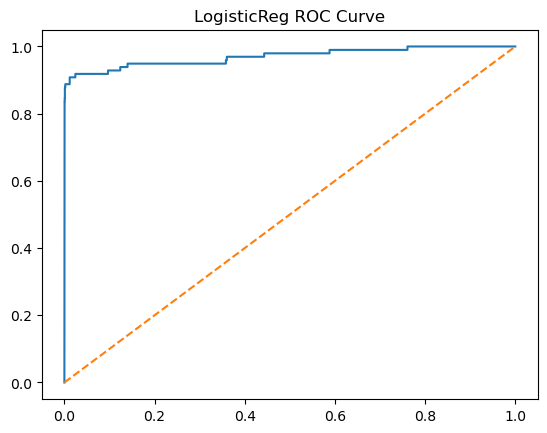


RandomForest metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



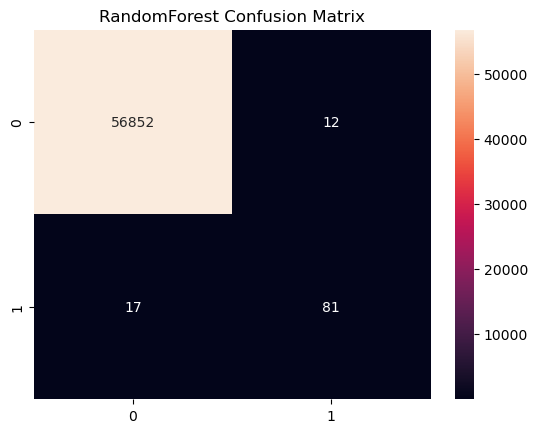

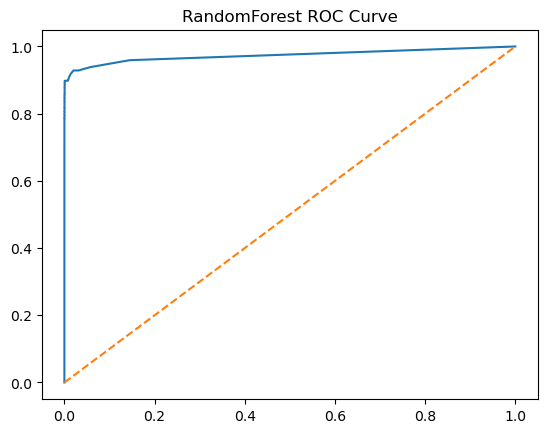


XGBoost metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.87      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



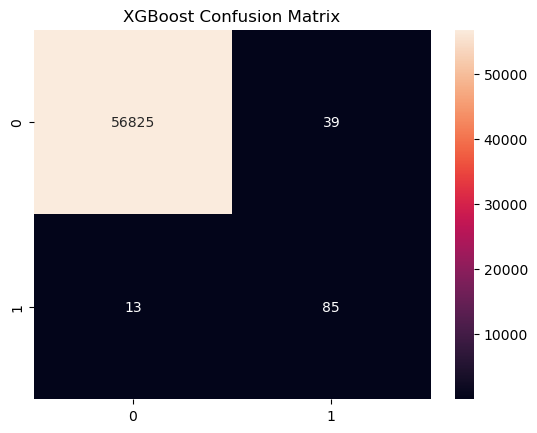

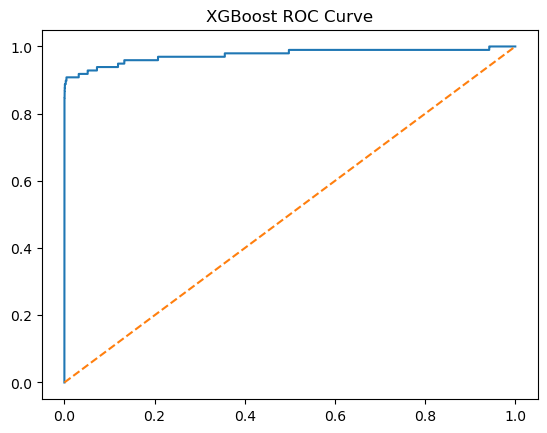

In [8]:
for name, model in [("LogisticReg", logreg), ("RandomForest", rf), ("XGBoost", xgb)]:
    evaluate(model, X_test, y_test, name)

7. Save best model

In [9]:
import joblib
best = xgb  # assuming XGBoost performed best
joblib.dump(best, 'best_ccf_model.pkl')

['best_ccf_model.pkl']